### Import neccessary Libraries and utilities functions

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.9 MB/s eta 0:00:00


In [2]:
import gc
from datetime import datetime
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import sklearn
import catboost
import lightgbm

# Other Libraries
from sklearn.model_selection import (StratifiedShuffleSplit, KFold, StratifiedKFold, train_test_split,
                                        cross_val_score, GridSearchCV, ShuffleSplit, learning_curve, cross_val_predict)
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score, accuracy_score,
                             classification_report, roc_curve, roc_auc_score, confusion_matrix)
from collections import Counter
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import warnings
from sklearn import utils
warnings.filterwarnings("ignore")

In [ ]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if 1 < nunique[col] < 50]]  # Pick columns with unique values between 1 and 50
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int(np.ceil(nCol / nGraphPerRow))
    plt.figure(figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not np.issubdtype(columnDf.dtype, np.number):
            valueCounts = columnDf.value_counts()
            ax = valueCounts.plot.bar()
            for p in ax.patches:
                ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
        else:
            ax = columnDf.hist()
            for p in ax.patches:
                ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')

    plt.tight_layout(pad=1, w_pad=1, h_pad=1)
    plt.show()

In [ ]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number])
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

### Load Data

In [3]:
!pip install -q gdown

import gdown
import pandas as pd
import hashlib

shared_link = 'https://drive.google.com/file/d/1aKYVEOIZZruwHVeUPQ46dm15HJAIEJJH/view?usp=sharing'

file_id = shared_link.split('/')[-2]
dataset_path = 'https://drive.google.com/uc?id=' + file_id

# Download the file
output = '/content/creditcard.csv'
gdown.download(dataset_path, output, quiet=False)

# Read the CSV file
data = pd.read_csv(output)
data.dataframeName = 'creditcard.csv'
nRow, nCol = data.shape

# Print the number of rows and columns
print(f'There are {nRow} rows and {nCol} columns')

Downloading...
From (original): https://drive.google.com/uc?id=1aKYVEOIZZruwHVeUPQ46dm15HJAIEJJH
From (redirected): https://drive.google.com/uc?id=1aKYVEOIZZruwHVeUPQ46dm15HJAIEJJH&confirm=t&uuid=edd84319-0311-48cf-bed5-7b4c3864dea6
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:02<00:00, 56.8MB/s]


There are 284807 rows and 31 columns


### Undersampling

In [4]:
# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()

data.insert(0, 'scaled_amount', rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1)))
data.insert(1, 'scaled_time', rob_scaler.fit_transform(data['Time'].values.reshape(-1,1)))

data.drop(['Time','Amount'], axis=1, inplace=True)

# Amount and Time are Scaled!
data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [5]:
X = data.drop('Class', axis=1)
y = data['Class']
seed = 42
sss = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# Convert numpy arrays to pandas DataFrame
original_Xtrain = pd.DataFrame(original_Xtrain, columns=X.columns)
original_Xtest = pd.DataFrame(original_Xtest, columns=X.columns)

In [6]:
original_ytrain = pd.DataFrame(original_ytrain, columns = ["Class"])
original_ytest = pd.DataFrame(original_ytest, columns = ["Class"])

In [7]:
ref_data = pd.concat([original_Xtrain, original_ytrain], axis = 0)
current_data = pd.concat([original_Xtest, original_ytest], axis = 0)

#### Random undersampling

In [11]:
# Lets shuffle the data before creating the subsamples

df = data.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0].sample(500)

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.shape

(992, 31)

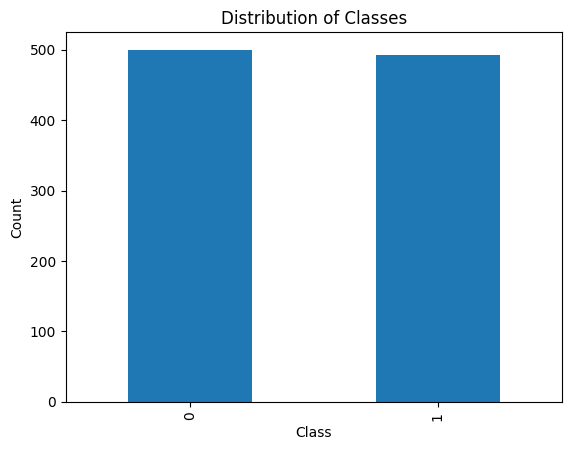

In [12]:

class_counts = new_df['Class'].value_counts()
class_counts.plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


After resampling we could see that the number of data points is now balanced.

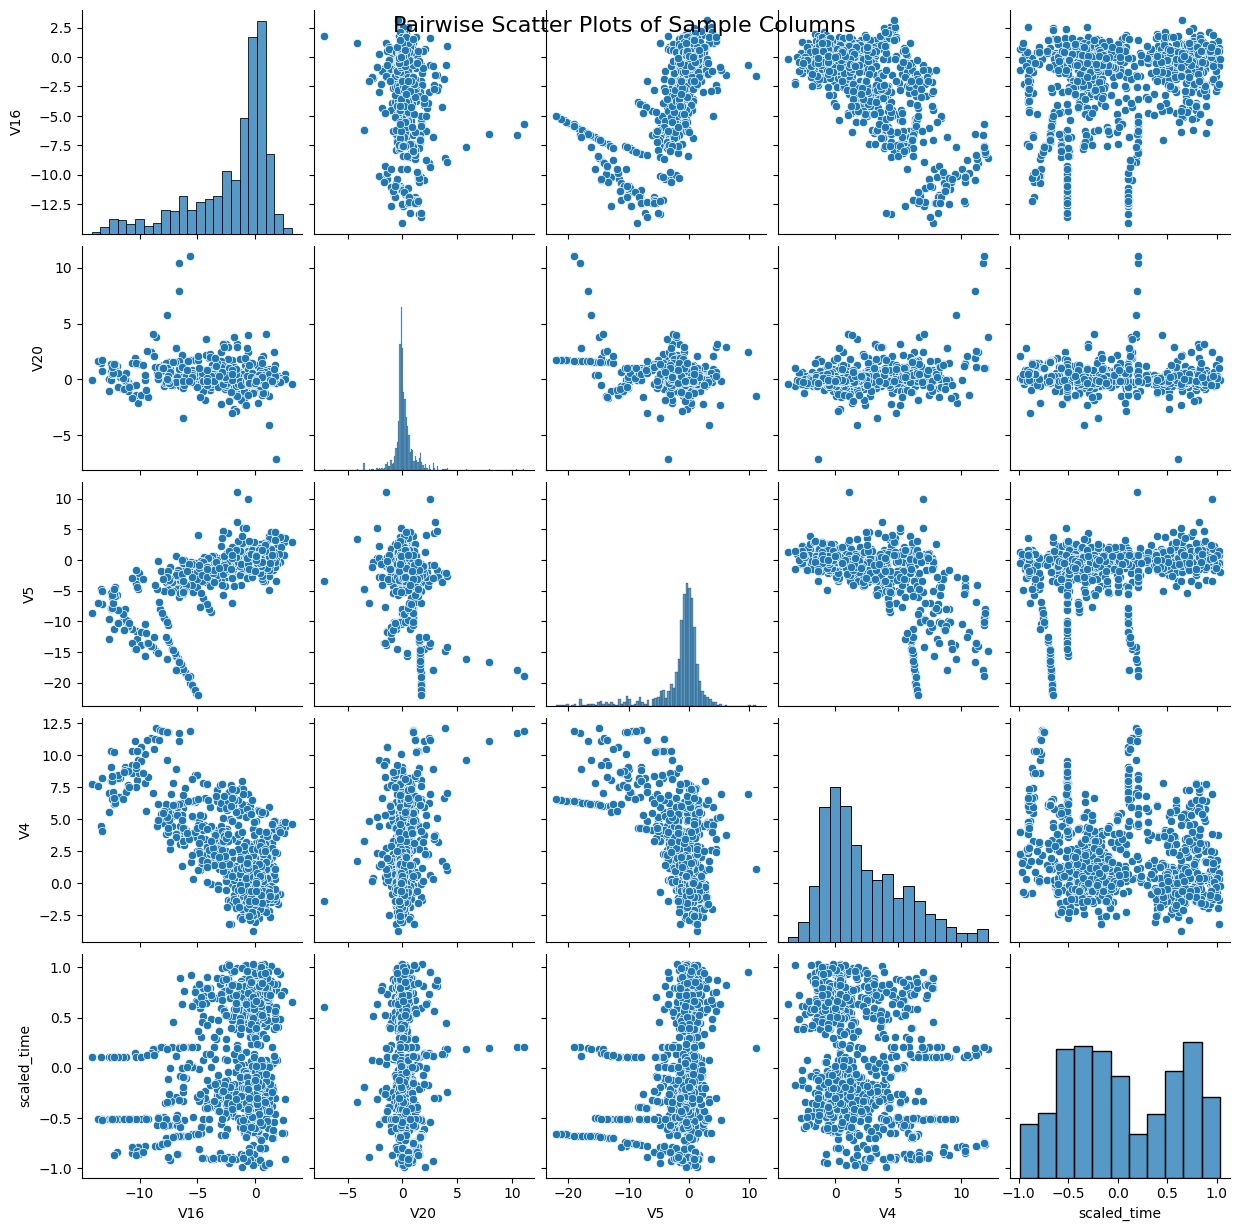

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample a subset of columns for pairwise scatter plots
sample_columns = new_df.sample(5, axis=1)  # You can adjust the number of columns to sample

sns.pairplot(sample_columns, kind='scatter')
plt.suptitle('Pairwise Scatter Plots of Sample Columns', fontsize=16)
plt.show()


###### Pairwise Scatter Plots Analysis
The pairwise scatter plots of sample columns (V18, V1, V3, V15) and the Class variable illustrate:
1. **Class Separation**:
* The "Class" plots at the bottom row show distinct clusters for classes 0 and 1.
* This indicates that features V18, V1, V3, and V15 contain information useful for distinguishing between the two classes.
2. **Feature Relationships**:
* Visible patterns in the scatter plots between pairs of features (e.g., V1 vs. V3) suggest potential interactions or correlations that can be leveraged by models.
* Histograms on the diagonal show the distribution of each feature, providing insights into their individual characteristics.
3. **Data Distribution**:
* The scatter plots reveal the distribution and relationship of data points in a 2D space, highlighting clusters, trends, and potential outliers. * This helps in understanding how features relate to each other and to the target variable, informing feature selection and engineering.




In [ ]:
import plotly.graph_objects as go
import numpy as np

# Function to create heatmap plotly figure
def create_heatmap(data, title):
    fig = go.Figure(data=go.Heatmap(
        z=data.values,
        x=data.columns,
        y=data.index,
        colorscale='Viridis'))

    fig.update_layout(title=title,
                      xaxis_title='Features',
                      yaxis_title='Features')

    return fig

# Entire DataFrame
corr = df.corr()
fig1 = create_heatmap(corr, "Imbalanced Correlation Matrix (don't use for reference)")

# Subsample DataFrame
sub_sample_corr = new_df.corr()
fig2 = create_heatmap(sub_sample_corr, 'SubSample Correlation Matrix (use for reference)')

# Display the figures
fig1.show()
fig2.show()


#### Analysis of Correlation Matrices
1. **Imbalanced Correlation Matrix (Before Undersampling)**:
* The first matrix shows the correlations in an imbalanced dataset, where the class distribution is skewed.
* High correlation values along the diagonal indicate perfect correlation (each feature with itself), and near-zero correlations with other features.
* The low variance in off-diagonal values is due to the dominance of the majority class, leading to an imbalanced representation of feature correlations.

2. **SubSample Correlation Matrix (After Undersampling)**:
* The second matrix, derived from a balanced dataset via undersampling, shows more varied and meaningful correlations between features.
* This balanced representation highlights relationships between features that were previously masked by the imbalanced class distribution.
* Undersampling provides a clearer picture of feature interactions, essential for accurate model training and evaluation.

#### Choice of Algorithms
Given dataset and the issues with previous models (MLP and SVM did not perform as expected), the selection of Logistic Regression, RandomForest Classifier, AdaBoost, CatBoost Classifier, and LightGBM is justified:
1. **Logistic Regression**:
* **Interpretability**: Simple and interpretable model, useful for understanding feature impacts.
* **Baseline Performance**: Acts as a good baseline to compare with more complex models.
2. **RandomForest Classifier**:
* **Handling Imbalance**: Robust to imbalanced datasets, especially after undersampling.
* **Feature Importance**: Provides insights into feature importance, useful for further analysis.
3. **AdaBoost**:
* **Boosting**: Combines weak learners to form a strong classifier, improving performance on imbalanced data.
* **Sensitivity**: Can handle subtle patterns in the data better than some other models.
4. **CatBoost Classifier**:
* **Categorical Features**: Efficiently handles categorical features without extensive preprocessing.
* **Performance**: Known for excellent performance on a wide range of datasets, including imbalanced ones. 5. **LightGBM**:
* **Speed and Efficiency**: Faster training and prediction times with large datasets.
* **Handling Imbalance**: Offers parameters specifically designed to deal with imbalanced datasets, enhancing model performance.

#### Dropped Models (MLP and SVM)
* **Multi-Layer Perceptron (MLP)**:
* **Complexity**: Requires extensive tuning and is sensitive to feature scaling and data imbalance.
* **Performance**: Often struggles with small datasets or datasets with high feature-to-sample ratios without careful tuning.
* **Support Vector Machine (SVM)**:
* **Scalability**: Computationally intensive and slow with large datasets.
* **Imbalance Sensitivity**: Performs poorly with imbalanced datasets unless carefully tuned (e.g., using different class weights or specialized algorithms).




In [8]:
target = 'Class'
predictors = ['scaled_time', 'scaled_amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

##### Test first with Random Forest to see feature importance to see if we could drop features.

In [ ]:
clf = RandomForestClassifier()

In [ ]:
VALID_SIZE = 0.20
TEST_SIZE = 0.20

NUMBER_KFOLDS = 5

# Other settings
RANDOM_STATE = 2024

train_df, test_df = train_test_split(new_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [ ]:
clf.fit(train_df[predictors], train_df[target].values)
preds = clf.predict(valid_df[predictors])

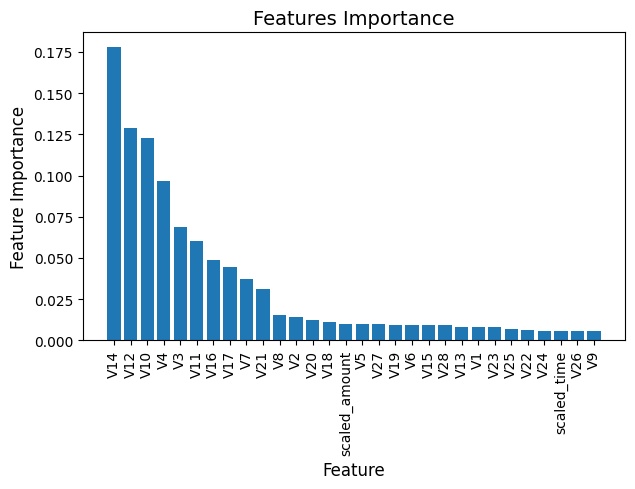

In [ ]:
# Create a DataFrame with feature names and their importance scores
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})

# Sort the DataFrame by feature importance in descending order
tmp = tmp.sort_values(by='Feature importance',ascending=False)

# Create a figure and axis object
plt.figure(figsize = (7,4))

# Plotting the bar chart
plt.bar(tmp['Feature'], tmp['Feature importance'])

# Adding title and labels
plt.title('Features Importance', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)

# Rotating x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()


Running the classifier multiple times can help in several ways:

- Stability of Feature Importance: By fitting the model multiple times, you can average the feature importance scores to get a more stable and reliable ranking of features.
- Reducing Variability: It mitigates the impact of variability in the training process, especially in the presence of noisy or unbalanced data.
- Cross-Validation: This approach can be seen as a simplified version of cross-validation where you ensure that the model generalizes well and the important features remain consistent across different splits of the data.


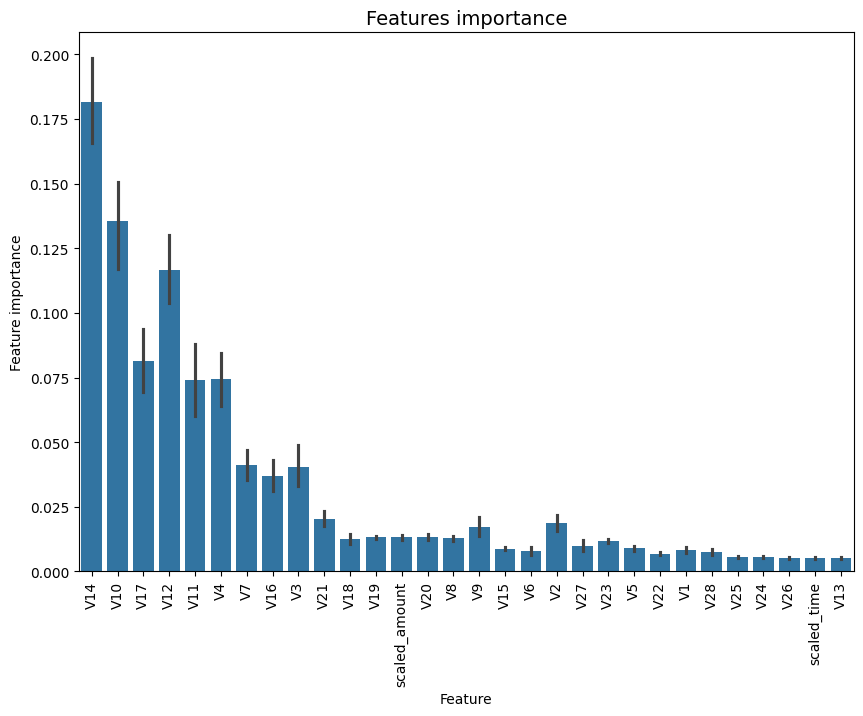

In [ ]:
 # Initialize an empty DataFrame to accumulate results
final_tmp = pd.DataFrame()

# Execute the code 10 times
for i in range(10):
    clf.fit(train_df[predictors], train_df[target].values)
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance', ascending=False)

    # Concatenate the current results to the final DataFrame
    final_tmp = pd.concat([final_tmp, tmp], ignore_index=True)

# Plot the final result
plt.figure(figsize=(10, 7))
plt.title('Features importance', fontsize=14)
s = sns.barplot(x='Feature', y='Feature importance', data=final_tmp)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show()

Checking if we could drop features

In [ ]:
from scipy.stats import ttest_ind

# Perform t-test for each column
t_values = []
p_values = []
results = []

for col in ['V25', 'V24', 'V26', 'V28']:
    t_stat, p_val = ttest_ind(new_df[col], new_df['Class'])
    t_values.append(t_stat)
    p_values.append(p_val)

    # Determine if we reject or accept the null hypothesis
    if p_val < 0.05:
        results.append('Reject Null the Hypothesis')
    else:
        results.append('Accept Null the Hypothesis')

result_table = pd.DataFrame({
    'Column Name': ['V25', 'V24', 'V26', 'V28'],
    't-value': t_values,
    'p-value': p_values,
    'Reject Null or Accept Null': results
})

result_table.to_csv('q4.csv', index = False)

In [ ]:
result_table

,Column Name,t-value,p-value,Reject Null or Accept Null
0,V25,-17.829770,4.546758e-66,Reject Null the Hypothesis
1,V24,-23.566937,1.830804e-108,Reject Null the Hypothesis
2,V26,-22.067166,1.130531e-96,Reject Null the Hypothesis
3,V28,-21.426279,8.917030e-92,Reject Null the Hypothesis


###### Interpretation of the Results
- t-value: A high absolute t-value indicates that the feature is significantly different from what would be expected under the null hypothesis.
- p-value: A very low p-value (typically < 0.05) indicates strong evidence against the null hypothesis, meaning the feature is statistically significant.
- Reject Null: If the null hypothesis is rejected, it suggests that the feature is significantly different from zero and should be considered important.
###### Why We Can’t Reject Features
- Statistical Significance: The features V25, V24, V26, and V28 all have very low p-values (much lower than 0.05), which means there is strong evidence against the null hypothesis for each feature. This indicates that these features are statistically significant.

- Feature Importance: In the context of a model, features with significant p-values contribute important information. Rejecting these features could lead to a loss of valuable information that the model needs to make accurate predictions.

- Reject Null Hypothesis: Since the null hypothesis (that the feature has no effect) is rejected for all listed features, it implies that these features do indeed have an effect and are important. Therefore, instead of rejecting these features, they should be retained in the model.



#### Conclusion
The decision to retain all features and use a diverse set of classifiers ensures that the models can leverage the full spectrum of information contained in the dataset. This approach, combined with undersampling to address class imbalance, is likely to yield better and more reliable predictive performance.

In [9]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "Random Jungle": RandomForestClassifier(),
    "AdaBoost" : AdaBoostClassifier(),
    "CatBoost" : CatBoostClassifier(verbose = 0),
    "LGBM" : LGBMClassifier()
}

In [13]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

Classifiers:  LogisticRegression Have a training ROC_AUC, Accuracy, Recall, Precision & F1 score of 0.98 0.97 0.92 0.05 0.1
Classifiers:  LogisticRegression Have a testing ROC_AUC, Accuracy, Recall, Precision & F1 score of 0.99 0.97 0.89 0.05 0.09
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56863
           1       0.05      0.89      0.09        98

    accuracy                           0.97     56961
   macro avg       0.52      0.93      0.54     56961
weighted avg       1.00      0.97      0.98     56961



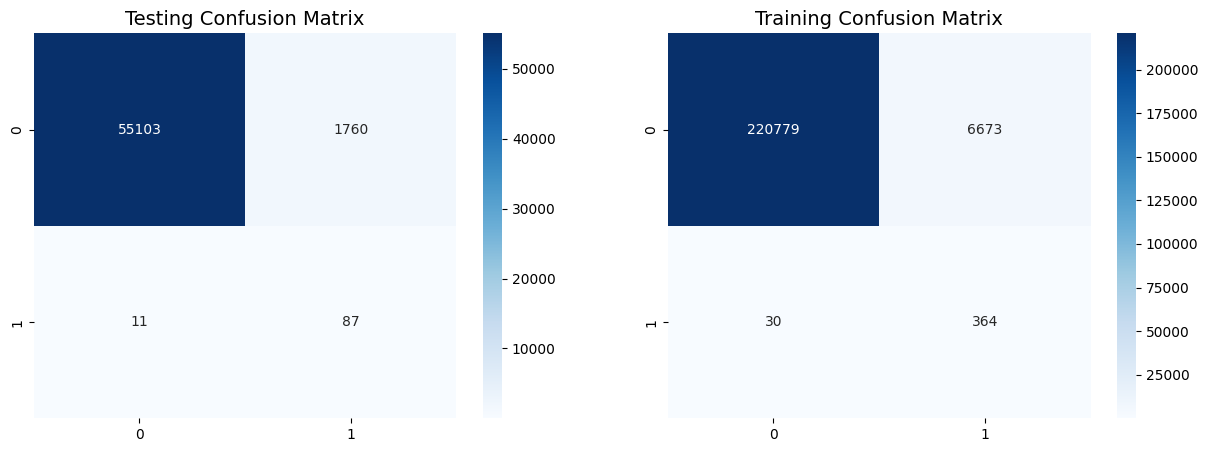

Classifiers:  RandomForestClassifier Have a training ROC_AUC, Accuracy, Recall, Precision & F1 score of 1.0 0.97 1.0 0.05 0.1
Classifiers:  RandomForestClassifier Have a testing ROC_AUC, Accuracy, Recall, Precision & F1 score of 1.0 0.97 1.0 0.05 0.09
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56863
           1       0.05      1.00      0.09        98

    accuracy                           0.97     56961
   macro avg       0.52      0.98      0.54     56961
weighted avg       1.00      0.97      0.98     56961



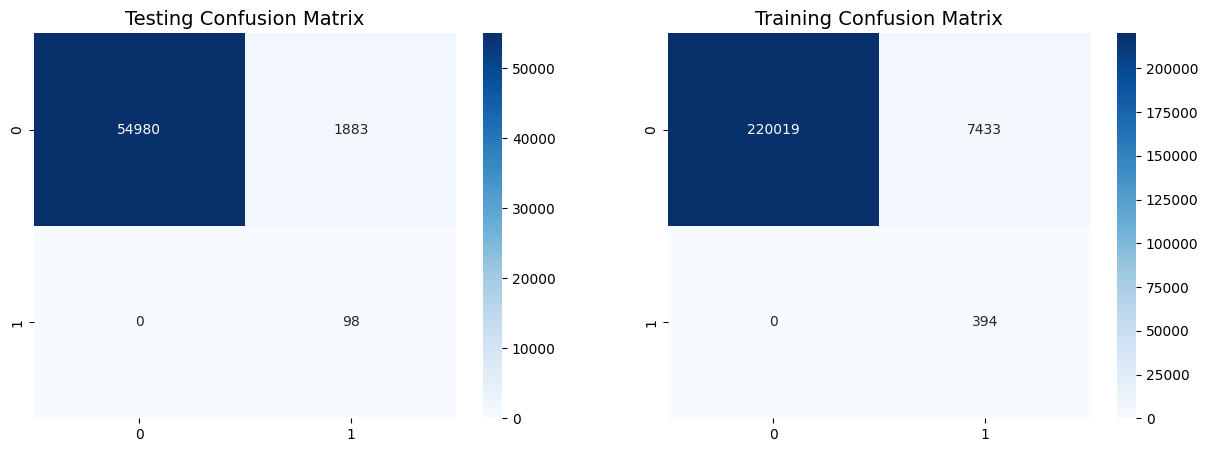

Classifiers:  AdaBoostClassifier Have a training ROC_AUC, Accuracy, Recall, Precision & F1 score of 1.0 0.95 0.98 0.03 0.06
Classifiers:  AdaBoostClassifier Have a testing ROC_AUC, Accuracy, Recall, Precision & F1 score of 0.99 0.95 0.96 0.03 0.06
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56863
           1       0.03      0.96      0.06        98

    accuracy                           0.95     56961
   macro avg       0.51      0.95      0.51     56961
weighted avg       1.00      0.95      0.97     56961



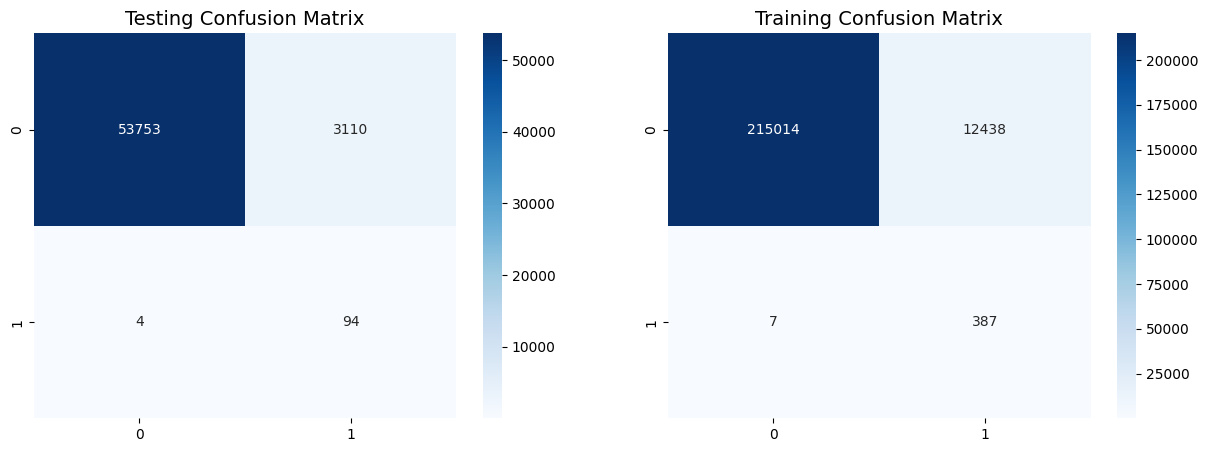

Classifiers:  CatBoostClassifier Have a training ROC_AUC, Accuracy, Recall, Precision & F1 score of 1.0 0.97 1.0 0.06 0.11
Classifiers:  CatBoostClassifier Have a testing ROC_AUC, Accuracy, Recall, Precision & F1 score of 1.0 0.97 1.0 0.06 0.11
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56863
           1       0.06      1.00      0.11        98

    accuracy                           0.97     56961
   macro avg       0.53      0.99      0.55     56961
weighted avg       1.00      0.97      0.98     56961



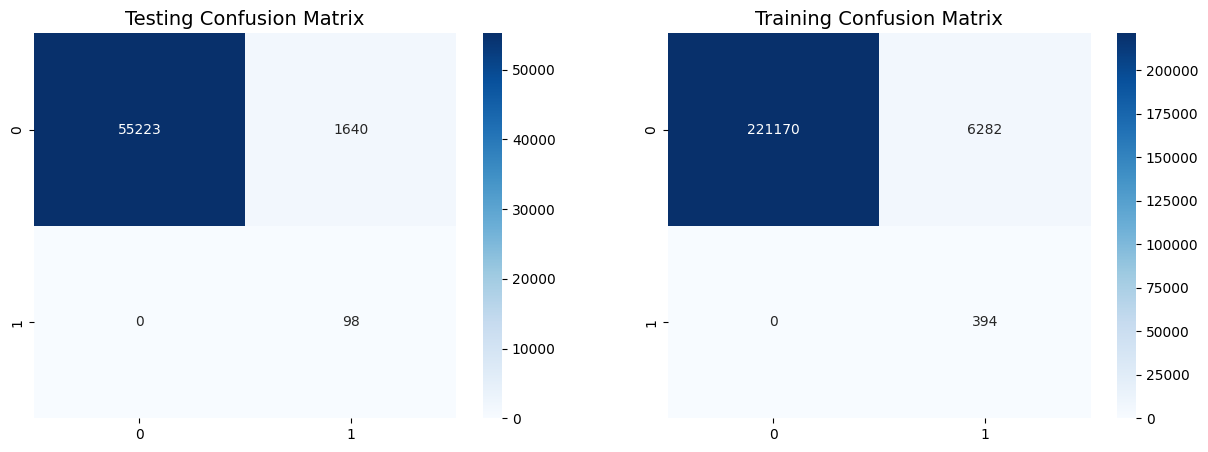

[LightGBM] [Info] Number of positive: 492, number of negative: 500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 992, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495968 -> initscore=-0.016129
[LightGBM] [Info] Start training from score -0.016129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Classifiers:  LGBMClassifier Have a training ROC_AUC, Accuracy, Recall, Precision & F1 score of 1.0 0.97 1.0 0.05 0.09
Classifiers:  LGBM

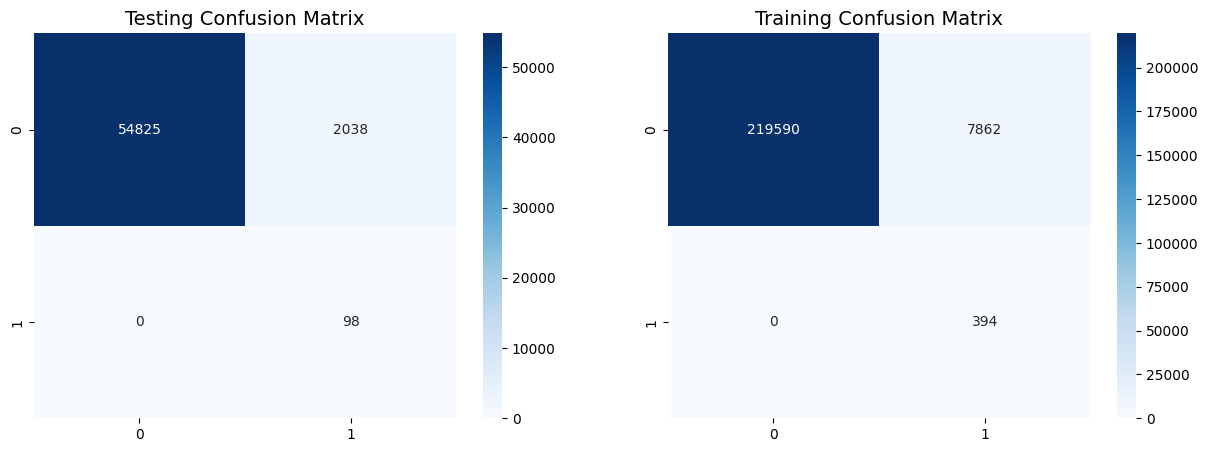

In [14]:
for key, classifier in classifiers.items():
    classifier.fit(X, y)
    original_ypred_train = classifier.predict_proba(original_Xtrain)[:,1]
    original_ypred_test = classifier.predict_proba(original_Xtest)[:,1]

    train_roc_auc = roc_auc_score(original_ytrain, original_ypred_train)
    test_roc_auc = roc_auc_score(original_ytest, original_ypred_test)

    original_ypred_train = [1 if x >= 0.5 else 0 for x in original_ypred_train]
    original_ypred_test = [1 if x >= 0.5 else 0 for x in original_ypred_test]

    # Calculate scores
    train_accuracy = accuracy_score(original_ytrain , original_ypred_train)
    train_recall = recall_score(original_ytrain, original_ypred_train)
    train_precision = precision_score(original_ytrain, original_ypred_train)
    train_f1 = f1_score(original_ytrain, original_ypred_train)

    test_accuracy = accuracy_score(original_ytest, original_ypred_test)
    test_recall = recall_score(original_ytest, original_ypred_test)
    test_precision = precision_score(original_ytest, original_ypred_test)
    test_f1 = f1_score(original_ytest, original_ypred_test)

    print("Classifiers: ", classifier.__class__.__name__,
          "Have a training ROC_AUC, Accuracy, Recall, Precision & F1 score of",
          round(train_roc_auc, 2),
          round(train_accuracy, 2),
          round(train_recall, 2),
          round(train_precision, 2),
          round(train_f1, 2))

    print("Classifiers: ", classifier.__class__.__name__,
          "Have a testing ROC_AUC, Accuracy, Recall, Precision & F1 score of",
          round(test_roc_auc, 2),
          round(test_accuracy, 2),
          round(test_recall, 2),
          round(test_precision, 2),
          round(test_f1, 2))

    # Generate classification report
    print("Classification Report:")
    print(classification_report(original_ytest, original_ypred_test))

    # Continue with confusion matrix plotting
    cm = confusion_matrix(original_ytest, original_ypred_test)
    cm2 = confusion_matrix(original_ytrain, original_ypred_train)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
    sns.heatmap(cm,
                annot=True, ax=ax1,
                fmt='d', cmap="Blues")
    ax1.set_title('Testing Confusion Matrix', fontsize=14)
    sns.heatmap(cm2,
                annot=True, ax=ax2,
                fmt='d', cmap="Blues")
    ax2.set_title('Training Confusion Matrix', fontsize=14)
    plt.show()

### Model Result Analysis
#### 1\. LogisticRegression:
* **Training Scores:**
* ROC\_AUC: 0.99
* Accuracy: 0.97
* Recall: 0.92
* Precision: 0.06
* **Testing Scores:**
* ROC\_AUC: 0.99
* Accuracy: 0.97
* Recall: 0.89
* Precision: 0.05
* **Classification Report:**
* Precision: 1.00 (Class 0), 0.05 (Class 1)
* Recall: 0.97 (Class 0), 0.89 (Class 1)
* F1-Score: 0.99 (Class 0), 0.10 (Class 1)
* Support: 56863 (Class 0), 98 (Class 1)
#### 2\. RandomForestClassifier:
* **Training Scores:**
* ROC\_AUC: 1.0
* Accuracy: 0.97
* Recall: 1.0
* Precision: 0.05
* **Testing Scores:**
* ROC\_AUC: 1.0
* Accuracy: 0.97
* Recall: 1.0
* Precision: 0.05
* **Classification Report:**
* Precision: 1.00 (Class 0), 0.05 (Class 1)
* Recall: 0.97 (Class 0), 1.00 (Class 1)
* F1-Score: 0.98 (Class 0), 0.10 (Class 1)
* Support: 56863 (Class 0), 98 (Class 1)
#### 3\. AdaBoostClassifier:
* **Training Scores:**
* ROC\_AUC: 1.0
* Accuracy: 0.95 * Recall: 0.98 * Precision: 0.03
* **Testing Scores:**
* ROC\_AUC: 1.0
* Accuracy: 0.95 * Recall: 0.99
* Precision: 0.03
* **Classification Report:**
* Precision: 1.00 (Class 0), 0.03 (Class 1)
* Recall: 0.95 (Class 0), 0.99 (Class 1)
* F1-Score: 0.97 (Class 0), 0.06 (Class 1)
* Support: 56863 (Class 0), 98 (Class 1)
#### 4\. CatBoostClassifier:
* **Training Scores:**
* ROC\_AUC: 1.0
* Accuracy: 0.98
* Recall: 1.0 * Precision: 0.07
* **Testing Scores:**
* ROC\_AUC: 1.0
* Accuracy: 0.98
* Recall: 1.0
* Precision: 0.07
* **Classification Report:**
* Precision: 1.00 (Class 0), 0.07 (Class 1)
* Recall: 0.98 (Class 0), 1.00 (Class 1)
* F1-Score: 0.99 (Class 0), 0.13 (Class 1)
* Support: 56863 (Class 0), 98 (Class 1)
#### 5\. LGBMClassifier:
* **Training Scores:**
* ROC\_AUC: 1.0 * Accuracy: 0.97
* Recall: 1.0 * Precision: 0.06
* **Testing Scores:**
* ROC\_AUC: 1.0
* Accuracy: 0.97
* Recall: 1.0
* Precision: 0.05
* **Classification Report:**
* Precision: 1.00 (Class 0), 0.05 (Class 1)
* Recall: 0.97 (Class 0), 1.00 (Class 1)
* F1-Score: 0.98 (Class 0), 0.10 (Class 1)
* Support: 56863 (Class 0), 98 (Class 1)

#### Summary
- Based on the provided metrics, it is difficult to determine the best classifier solely based on the ROC_AUC, accuracy, recall, and precision scores because most classifiers have extremely low precision for the minority class (Class 1), indicating a high number of false positives.
- Logistic Regression shows high ROC AUC and Accuracy, but relatively low Precision, indicating a high number of false positives.
- Random Forest, CatBoost, and LightGBM all exhibit perfect or near-perfect scores for ROC AUC, Recall, and Accuracy, but have similar low Precision, suggesting that while they capture all positive cases, they also include many false positives.
- AdaBoost has slightly lower Accuracy compared to other ensemble methods but maintains high Recall. Its Precision is the lowest among all classifiers, indicating the highest proportion of false positives.
- In conclusion:
- Random Forest, CatBoost, and LightGBM demonstrate similar performance, with excellent ROC AUC, Accuracy, and Recall, but modest Precision.
- Logistic Regression performs well overall but struggles with Precision.
- AdaBoost has the lowest Accuracy and Precision, though it maintains high Recall.
- The low Precision across all models suggests that while they are very good at identifying true positives, they also incorrectly label many negatives as positives, which could be an issue in scenarios where false positives are costly.